In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [13]:
# Constants (replace these with your actual values)
N = 7  # length of Name
S = 9   # length of Surname
I1 = 0  # last digit of study book number
I2 = 4  # next to last digit of study book number

In [16]:
tau = 1 / (1 + I1)
alpha1 = 0.1
alpha2 = 0.01
p1 = alpha1 ** (1 - tau) * alpha2 ** tau
p2 = 10 * np.sqrt(S) * p1

theta0 = (N, S + 2)  # (scale, shape) for G0

In [18]:
def calculate_theta1(theta0):
    mu0 = stats.pareto.mean(*theta0)
    var0 = stats.pareto.var(*theta0)
    
    def equations(params):
        scale, shape = params
        return (stats.pareto.mean(scale, shape) - mu0,
                stats.pareto.var(scale, shape) - N * var0)
    
    from scipy.optimize import fsolve
    return fsolve(equations, theta0)

def calculate_theta2(theta0):
    mu0 = stats.pareto.mean(*theta0)
    var0 = stats.pareto.var(*theta0)
    
    def equations(params):
        scale, shape = params
        return (stats.pareto.mean(scale, shape) - (mu0 + 2 * np.sqrt(var0)),
                stats.pareto.var(scale, shape) - S * var0)
    
    from scipy.optimize import fsolve
    return fsolve(equations, theta0)

theta1 = calculate_theta1(theta0)
theta2 = calculate_theta2(theta0)

def generate_mixture_sample(n, p, theta1, theta2):
    n1 = np.random.binomial(n, p)
    sample1 = stats.pareto.rvs(*theta1, size=n1)
    sample2 = stats.pareto.rvs(*theta0, size=n-n1)
    return np.concatenate([sample1, sample2])

def kolmogorov_smirnov_test(sample, theta0):
    return stats.kstest(sample, lambda x: stats.pareto.cdf(x, *theta0))

def cramer_von_mises_test(sample, theta0):
    n = len(sample)
    sample_cdf = np.arange(1, n + 1) / n
    theoretical_cdf = stats.pareto.cdf(np.sort(sample), *theta0)
    return n * np.sum((sample_cdf - theoretical_cdf) ** 2) + 1 / (12 * n)

def anderson_darling_test(sample, theta0):
    n = len(sample)
    sample_sorted = np.sort(sample)
    cdf = stats.pareto.cdf(sample_sorted, *theta0)
    ad_sum = -n - np.sum((2 * np.arange(1, n + 1) - 1) * (np.log(cdf) + np.log(1 - cdf[::-1]))) / n
    return ad_sum

def dkw_inequality(sample, theta0, alpha):
    n = len(sample)
    epsilon = np.sqrt(np.log(2 / alpha) / (2 * n))
    sample_cdf = np.arange(1, n + 1) / n
    theoretical_cdf = stats.pareto.cdf(np.sort(sample), *theta0)
    return np.max(np.abs(sample_cdf - theoretical_cdf)) <= epsilon

def run_tests(sample_size, mixture_prob, alpha):
    sample = generate_mixture_sample(sample_size, mixture_prob, theta1, theta2)
    
    ks_stat, ks_pvalue = kolmogorov_smirnov_test(sample, theta0)
    cm_stat = cramer_von_mises_test(sample, theta0)
    ad_stat = anderson_darling_test(sample, theta0)
    dkw_result = dkw_inequality(sample, theta0, alpha)
    
    print(f"Sample size: {sample_size}, Mixture probability: {mixture_prob:.4f}")
    print(f"Kolmogorov-Smirnov test: statistic = {ks_stat:.4f}, p-value = {ks_pvalue:.4f}")
    print(f"Cramér-von Mises test: statistic = {cm_stat:.4f}")
    print(f"Anderson-Darling test: statistic = {ad_stat:.4f}")
    print(f"Dvoretzky-Kiefer-Wolfowitz inequality: {dkw_result}")
    print()

Sample size: 90, Mixture probability: 0.0100
Kolmogorov-Smirnov test: statistic = 0.0587, p-value = 0.8977
Cramér-von Mises test: statistic = 4.6013
Anderson-Darling test: statistic = 0.2910
Dvoretzky-Kiefer-Wolfowitz inequality: True

Sample size: 90, Mixture probability: 0.3000
Kolmogorov-Smirnov test: statistic = 0.0787, p-value = 0.6044
Cramér-von Mises test: statistic = 4.7562
Anderson-Darling test: statistic = 0.3852
Dvoretzky-Kiefer-Wolfowitz inequality: True

Sample size: 900, Mixture probability: 0.0100
Kolmogorov-Smirnov test: statistic = 0.0205, p-value = 0.8359
Cramér-von Mises test: statistic = 33.8395
Anderson-Darling test: statistic = 0.2585
Dvoretzky-Kiefer-Wolfowitz inequality: True

Sample size: 900, Mixture probability: 0.3000
Kolmogorov-Smirnov test: statistic = 0.0157, p-value = 0.9771
Cramér-von Mises test: statistic = 27.0434
Anderson-Darling test: statistic = 0.2383
Dvoretzky-Kiefer-Wolfowitz inequality: True

Sample size: 90, Mixture probability: 0.0100
Kolmogo

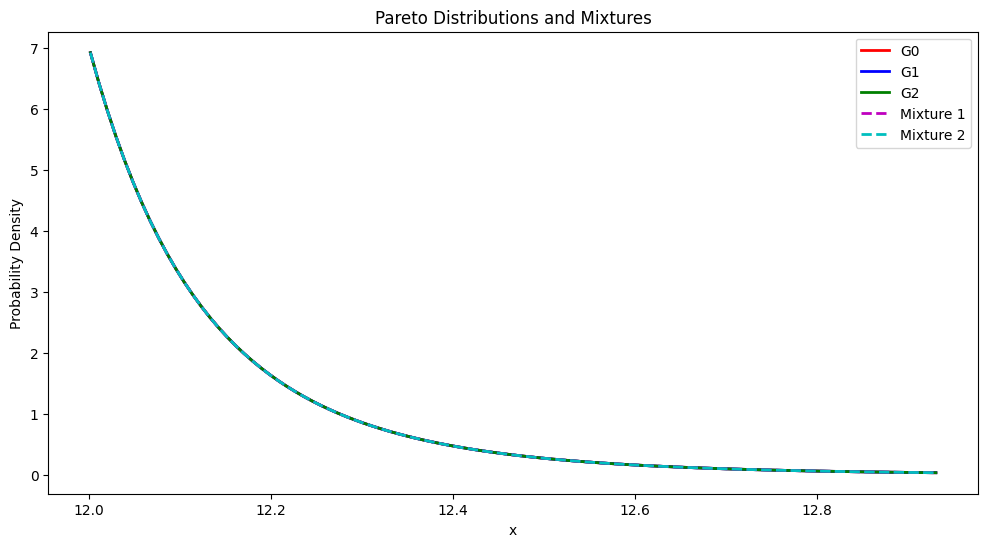

In [19]:
# Run tests
for alpha in [alpha1, alpha2]:
    for sample_size in [10 * (2 + N), 100 * (2 + N)]:
        run_tests(sample_size, p1, alpha)
        run_tests(sample_size, p2, alpha)

# Visualize the distributions
x = np.linspace(stats.pareto.ppf(0.01, *theta0), stats.pareto.ppf(0.99, *theta0), 100)

plt.figure(figsize=(12, 6))
plt.plot(x, stats.pareto.pdf(x, *theta0), 'r-', lw=2, label='G0')
plt.plot(x, stats.pareto.pdf(x, *theta1), 'b-', lw=2, label='G1')
plt.plot(x, stats.pareto.pdf(x, *theta2), 'g-', lw=2, label='G2')
plt.plot(x, (1-p1)*stats.pareto.pdf(x, *theta0) + p1*stats.pareto.pdf(x, *theta1), 'm--', lw=2, label='Mixture 1')
plt.plot(x, (1-p2)*stats.pareto.pdf(x, *theta0) + p2*stats.pareto.pdf(x, *theta2), 'c--', lw=2, label='Mixture 2')
plt.legend()
plt.title('Pareto Distributions and Mixtures')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.show()